<h1>Programming Exercise 3: 
    Multi-class Classification and Neural Networks

<h3> Introduction </h3>
In this exercise, we will implement one-vs-all logistic regression and neural networks to recognize hand-written digits. 

<h4>Files included in this exercise:</h4>
- ex3data1.mat
- ex3weights.mat
- neuralnetwork.png

<h3>1 Multi-class Classification</h3>
Here we will use logistic regression and neural networks to recognize handwritten digits (ranging from 0 to 9). To start we will extend our previous implementation of logistic regression to one-vs-all classification, beginning with a visualization of the data

In [62]:
# used for manipulating directory paths
import os

# Scientific and vector computation for python
import numpy as np

# Plotting library
from matplotlib import pyplot as plt

# Optimization module in scipy
from scipy import optimize

# will be used to load MATLAB mat datafile format
from scipy.io import loadmat

# tells matplotlib to embed plots within the notebook
%matplotlib inline

import sys

In [63]:
# 20x20 Input Images of Digits
input_layer_size  = 400

# 10 labels, from 1 to 10 (note that we have mapped "0" to label 10)
num_labels = 10

#  training data stored in arrays X, y
data = loadmat(os.path.join('Data', 'ex3data1.mat'))
X, y = data['X'], data['y'].ravel()

# set the zero digit to 0, rather than its mapped 10 in this dataset
# This is an artifact due to the fact that this dataset was used in 
# MATLAB where there is no index 0
y[y == 10] = 0

m = y.size

In [64]:
def displayData(X, example_width=None, figsize=(10, 10)):
    """
    Displays 2D data stored in X in a nice grid.
    """
    # Compute rows, cols
    if X.ndim == 2:
        m, n = X.shape
    elif X.ndim == 1:
        n = X.size
        m = 1
        X = X[None]  # Promote to a 2 dimensional array
    else:
        raise IndexError('Input X should be 1 or 2 dimensional.')

    example_width = example_width or int(np.round(np.sqrt(n)))
    example_height = n / example_width

    # Compute number of items to display
    display_rows = int(np.floor(np.sqrt(m)))
    display_cols = int(np.ceil(m / display_rows))

    fig, ax_array = plt.subplots(display_rows, display_cols, figsize=figsize)
    fig.subplots_adjust(wspace=0.025, hspace=0.025)

    ax_array = [ax_array] if m == 1 else ax_array.ravel()

    for i, ax in enumerate(ax_array):
        ax.imshow(X[i].reshape(example_width, example_width, order='F'),
                  cmap='Greys', extent=[0, 1, 0, 1])
        ax.axis('off')


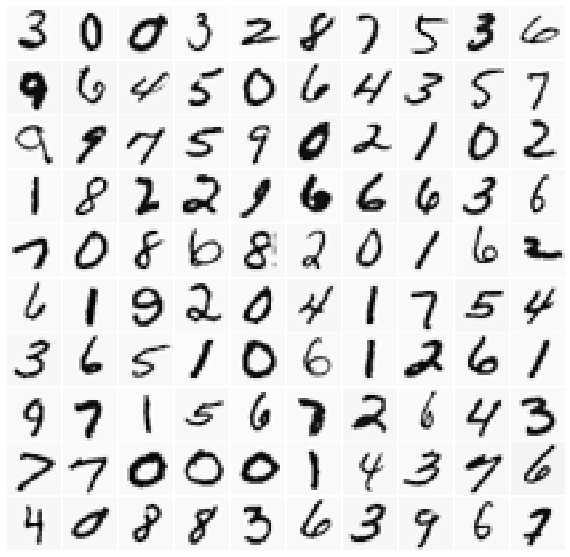

In [65]:
# Randomly select 100 data points to display
rand_indices = np.random.choice(m, 100, replace=False)
sel = X[rand_indices, :]

displayData(sel)

Now that we have an understanding of the data we are working with, we can implement a cost function for linear regression.

In [66]:
# test values for the parameters theta
theta_t = np.array([-2, -1, 1, 2], dtype=float)

# test values for the inputs
X_t = np.concatenate([np.ones((5, 1)), np.arange(1, 16).reshape(5, 3, order='F')/10.0], axis=1)

# test values for the labels
y_t = np.array([1, 0, 1, 0, 1])

# test value for the regularization parameter
lambda_t = 3

In [67]:
def sigmoid(z):
    """
    Compute sigmoid function given the input z.
    
    Parameters
    ----------
    z : array_like
        The input to the sigmoid function. This can be a 1-D vector 
        or a 2-D matrix. 
    
    Returns
    -------
    g : array_like
        The computed sigmoid function. g has the same shape as z, since
        the sigmoid is computed element-wise on z.
    """
    # convert input to a numpy array
    z = np.array(z)

    g = 1 + np.exp(-1*z)
    g = np.reciprocal(g)

    return g

In [68]:
def lrCostFunction(theta, X, y, lambda_):
    """
    Computes the cost of using theta as the parameter for regularized
    logistic regression and the gradient of the cost w.r.t. to the parameters.
    
    Parameters
    ----------
    theta : array_like
        Logistic regression parameters. A vector with shape (n, ). n is 
        the number of features including any intercept.  
    
    X : array_like
        The data set with shape (m x n). m is the number of examples, and
        n is the number of features (including intercept).
    
    y : array_like
        The data labels. A vector with shape (m, ).
    
    lambda_ : float
        The regularization parameter. 
    
    Returns
    -------
    J : float
        The computed value for the regularized cost function. 
    
    grad : array_like
        A vector of shape (n, ) which is the gradient of the cost
        function with respect to theta, at the current values of theta.
    
    """   
    # convert labels to ints if their type is bool
    if y.dtype == bool:
        y = y.astype(int)
    

    ## Initialize some useful values
    m = y.size
    J = 0
    grad = np.zeros(theta.shape)
    h = sigmoid(X.dot(theta))
    logh = np.log(h)
    tempLog = np.log(1-h)
    yTrans = y.transpose()
    Xtrans = X.transpose()
    tempTrans = (1-y).transpose()
    
    J = ((-yTrans).dot(logh))
    J = J - tempTrans.dot(tempLog)
    J = J * (1/m)
    J = J + (lambda_/(2*m))*np.sum(np.square(theta[1:]))
    
    diff = np.subtract(sigmoid(X.dot(theta)),y)
    grad = Xtrans.dot(diff)
    grad = grad * (1/m)
    grad[1:] = grad[1:] + (lambda_/m)*theta[1:]
        
    return J, grad

Now we can run our cost function on some test inputs to be sure it is running correctly. 

In [69]:
J, grad = lrCostFunction(theta_t, X_t, y_t, lambda_t)

print('Cost         : {:.6f}'.format(J))
print('-----------------------')
print('Gradients:')
print(' [{:.6f}, {:.6f}, {:.6f}, {:.6f}]'.format(*grad))


Cost         : 2.534819
-----------------------
Gradients:
 [0.146561, -0.548558, 0.724722, 1.398003]


Now that we have a working cost function, we can implement ove-vs all classification by training multiple regularized logistic regression classifiers, one for each our our K classes. Note that this classification will work for any value of K, not just our case where K = 10.

In [70]:
def oneVsAll(X, y, num_labels, lambda_):
    """
    Trains num_labels logistic regression classifiers and returns
    each of these classifiers in a matrix all_theta, where the i-th
    row of all_theta corresponds to the classifier for label i.
    
    Parameters
    ----------
    X : array_like
        The input dataset of shape (m x n). m is the number of 
        data points, and n is the number of features. Note that we 
        do not assume that the intercept term (or bias) is in X, however
        we provide the code below to add the bias term to X. 
    
    y : array_like
        The data labels. A vector of shape (m, ).
    
    num_labels : int
        Number of possible labels.
    
    lambda_ : float
        The logistic regularization parameter.
    
    Returns
    -------
    all_theta : array_like
        The trained parameters for logistic regression for each class.
        This is a matrix of shape (K x n+1) where K is number of classes
        (ie. `numlabels`) and n is number of features without the bias.
    """
    # Some useful variables
    m, n = X.shape
    all_theta = np.zeros((num_labels, n + 1))

    # Add ones to the X data matrix
    X = np.concatenate([np.ones((m, 1)), X], axis=1)
   
    for c in range(num_labels):
        initial_theta = np.zeros(n+1)
        options = {'maxiter': 50}
        res = optimize.minimize(lrCostFunction, 
                                initial_theta, 
                                (X, (y == c), lambda_), 
                                jac=True, 
                                method='TNC',
                                options=options) 
        all_theta[c,:] = res.x

    return all_theta

In [71]:
# Run oneVsAll optimization with lambda = 0.1 to get a prediction for theta
lambda_ = 0.1
all_theta = oneVsAll(X, y, num_labels, lambda_)

Now that we have a working oneVsAll classification, we can use the resulting theta to predict what an input should be classified as.

In [72]:
def predictOneVsAll(all_theta, X):
    """
    Return a vector of predictions for each example in the matrix X. 
    Note that X contains the examples in rows. all_theta is a matrix where
    the i-th row is a trained logistic regression theta vector for the 
    i-th class. You should set p to a vector of values from 0..K-1 
    (e.g., p = [0, 2, 0, 1] predicts classes 0, 2, 0, 1 for 4 examples) .
    
    Parameters
    ----------
    all_theta : array_like
        The trained parameters for logistic regression for each class.
        This is a matrix of shape (K x n+1) where K is number of classes
        and n is number of features without the bias.
    
    X : array_like
        Data points to predict their labels. This is a matrix of shape 
        (m x n) where m is number of data points to predict, and n is number 
        of features without the bias term. Note we add the bias term for X in 
        this function. 
    
    Returns
    -------
    p : array_like
        The predictions for each data point in X. This is a vector of shape (m, ).
    """
    m = X.shape[0];
    num_labels = all_theta.shape[0]
    p = np.zeros(m)

    # Add ones to the X data matrix
    X = np.concatenate([np.ones((m, 1)), X], axis=1)

    all_theta_T = all_theta.transpose()
    temp = sigmoid(X.dot(all_theta_T))
    for i in range(m):
        iTempMax = np.argmax(temp[i,:])
        p[i] = iTempMax

    return p

In [73]:
pred = predictOneVsAll(all_theta, X)
print('Training Set Accuracy: {:.2f}%'.format(np.mean(pred == y) * 100))

Training Set Accuracy: 95.14%


<h3>2 Neural Networks</h3>

We have now implemented multi-class logistic regression to recognize handwritten digits. However, because this is only a linear classifier, logistic regression cannot form more complex hypotheses. 
    In this portion of the exercise, we will implement a neural network to recognize handwritten digits using the same training set as before. The neural network will be able to represent more complex models to from non-linear hypotheses. In this exercise we will implement parameters from a neural network that has already been trained. Our goal is to implement the feedforward propagation algorithm to use our weights for prediction.
    Our neural network is shown in the following figure. it has 3 layers and takes as input our pixel values of digital images. This gives us 400 input layer units (plus our extra bias unit outputting +1). Our network parameters are stored in ex3weights.mat. We begin by loading them into Theta1 and Theta2.
    ![Neural network](Figures/neuralnetwork.png)

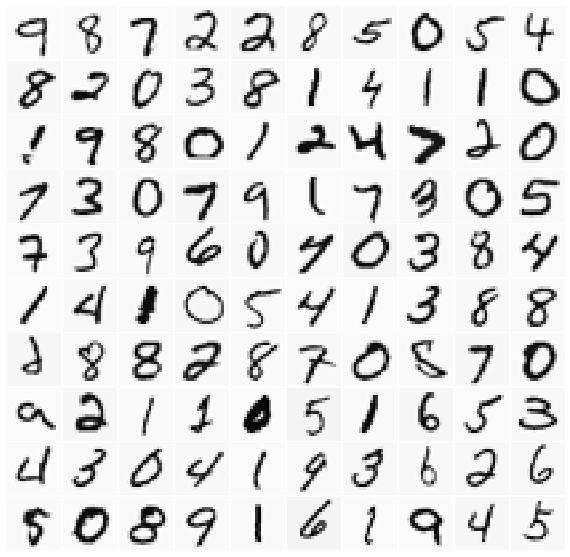

In [74]:
#  training data stored in arrays X, y
data = loadmat(os.path.join('Data', 'ex3data1.mat'))
X, y = data['X'], data['y'].ravel()

# set the zero digit to 0, rather than its mapped 10 in this dataset
# This is an artifact due to the fact that this dataset was used in 
# MATLAB where there is no index 0
y[y == 10] = 0

# get number of examples in dataset
m = y.size

# randomly permute examples, to be used for visualizing one 
# picture at a time
indices = np.random.permutation(m)

# Randomly select 100 data points to display
rand_indices = np.random.choice(m, 100, replace=False)
sel = X[rand_indices, :]

displayData(sel)

In [75]:
# Setup the parameters we will use for this exercise
input_layer_size  = 400  # 20x20 Input Images of Digits
hidden_layer_size = 25   # 25 hidden units
num_labels = 10          # 10 labels, from 0 to 9

# Load the .mat file, which returns a dictionary 
weights = loadmat(os.path.join('Data', 'ex3weights.mat'))

# get the model weights from the dictionary
# Theta1 has size 25 x 401
# Theta2 has size 10 x 26
Theta1, Theta2 = weights['Theta1'], weights['Theta2']

# swap first and last columns of Theta2, due to legacy from MATLAB indexing, 
# since the weight file ex3weights.mat was saved based on MATLAB indexing
Theta2 = np.roll(Theta2, 1, axis=0)

We will now implement in predict() the feedforward computation which computes predictions for each training sample.

In [76]:
def predict(Theta1, Theta2, X):
    """
    Predict the label of an input given a trained neural network.
    
    Parameters
    ----------
    Theta1 : array_like
        Weights for the first layer in the neural network.
        It has shape (2nd hidden layer size x input size)
    
    Theta2: array_like
        Weights for the second layer in the neural network. 
        It has shape (output layer size x 2nd hidden layer size)
    
    X : array_like
        The image inputs having shape (number of examples x image dimensions).
    
    Return 
    ------
    p : array_like
        Predictions vector containing the predicted label for each example.
        It has a length equal to the number of examples.
    """
    # Make sure the input has two dimensions
    if X.ndim == 1:
        X = X[None]  # promote to 2-dimensions
    
    # useful variables
    m = X.shape[0]
    num_labels = Theta2.shape[0]
    
    X = np.concatenate([np.ones((m, 1)), X], axis=1) # Add collumn of ones to X
    z2 = Theta1.dot(X.transpose())
    z2 = z2.transpose()
    a2 = sigmoid(z2)
    a2 = np.concatenate([np.ones((a2.shape[0], 1)), a2], axis=1) # Add collumn of ones to a2
    z3 = Theta2.dot(a2.transpose())
    a3 = sigmoid(z3)
    a3 = a3.transpose()
    p = np.argmax(a3, axis=1)

    return p

In [77]:
pred = predict(Theta1, Theta2, X)
print('Training Set Accuracy: {:.1f}%'.format(np.mean(pred == y) * 100))

Training Set Accuracy: 97.5%


Neural Network Prediction: 0


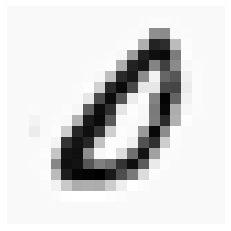

In [78]:
if indices.size > 0:
    i, indices = indices[0], indices[1:]
    displayData(X[i, :], figsize=(4, 4))
    pred = predict(Theta1, Theta2, X[i, :])
    print('Neural Network Prediction: {}'.format(*pred))
else:
    print('No more images to display!')